In [1]:
import torch
# import data_s2s
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from r3m import load_r3m
import pdb

os.environ["CUDA_VISIBLE_DEVICES"]="5"
snapshot_scratch = "/shared/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2022-07-27_18-08-35/snapshot_0.pt"
r3m_scratch = load_r3m('resnet50', snapshot_scratch).to('cuda:0')
r3m_scratch.eval()


/home/ademi_adeniji/anaconda3/envs/sr3m_base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ademi_adeniji/anaconda3/envs/sr3m_base/lib/python3.9/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTra

DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [2]:
def show_images(batch: torch.Tensor, size=None):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    images = Image.fromarray(reshaped.numpy())
    if size is not None:
        images = images.resize(size, Image.NEAREST)
    display(images)

def show_images_rlbench(batch: torch.Tensor, **kwargs):
    if batch.ndim == 3:
        batch = batch.unsqueeze(0)
    batch = batch / 255
    batch = batch * 2
    batch = batch - 1
    show_images(batch, **kwargs)
    
def show_images_ego4d(batch: torch.Tensor, **kwargs):
    if batch.ndim == 3:
        batch = batch.unsqueeze(0)
    batch = batch / 255
    batch = batch * 2
    batch = batch - 1
    show_images(batch, **kwargs)

In [20]:
import numpy as np
from PIL import Image, ImageSequence
from r3m.utils.data_loaders import R3MBuffer
import pandas as pd
import torchvision
import pdb
import tensorflow as tf
import random

sth_sth_process = False
ego4d_preprocessing = True
narrations = True


if sth_sth_process:
    # manifest = json.load(open('/shared/group/ego4d/v1/annotations/moments_train.json'))
    # vidid2vid = {}
    # i = 0
    # for vid in manifest['videos']:
    #     vidid2vid[vid['video_uid']] = vid
    #     i += 1
    #     if i == 100:
    #         break

    data_path = "/home/ademi_adeniji/ego4dclips/" 
    vid = data_path + 'c0e4d122-e7a9-4ed7-ac53-691906a43116'
    for i in range(0, 1000, 10):
        image = torchvision.io.read_image(f"{vid}/{i}.jpg")
        show_images_ego4d(image, size=(256, 256))
elif ego4d_preprocessing:
    if narrations:
        vidpath = "/home/ademi_adeniji/ego4d/videos2/"
        manifest_json = '/home/ademi_adeniji/ego4dstuff/narration.json'
        json = pd.read_json(manifest_json)
        uid = random.choice(json.keys())
        while json[uid]['narration_pass_1'] != json[uid]['narration_pass_1'] or len(json[uid]['narration_pass_1']['narrations']) == 0 or not os.path.exists(vidpath + uid):
            uid = random.choice(json.keys())
        narrations = json[uid]['narration_pass_1']['narrations']
        narration_idx = random.choice(range(len(narrations)))
        narration = narrations[narration_idx]
        vidpath = vidpath + uid
        start_frame = narration['timestamp_frame']
        try:
            next_narration = narrations[narration_idx+1]
            end_frame = next_narration['timestamp_frame']
        except:
            end_frame = start_frame + 10
        print(narration['narration_text'])
        print(vidpath)
        images = []
        for image in range(start_frame, end_frame, 1):
            load = tf.keras.preprocessing.image.load_img(
                          vidpath+f"/{image:07}.jpg",
                          grayscale=False,
                          color_mode='rgb',
                      )
            images.append(load)
        ims = tf.cast(tf.stack([tf.keras.preprocessing.image.img_to_array(x) for x in images], 0), tf.float32)
        for im in ims:
            show_images_ego4d(torch.from_numpy(im.numpy()).permute((2, 0, 1)), size=(256, 256))
    else:
        manifest_csv = '/home/ademi_adeniji/ego4d/videos2/manifest.csv'
        labels = csv['label'].unique()
        csv = pd.read_csv(manifest_csv)
        print(num_tasks)
        print(len(csv))
        label = 'use_the_microwave_/_warm_something_in_the_microwave'
        vid_csv = csv[csv['label'] == label]
        vid_csv = vid_csv.sample(n=1).iloc[0]
        vidpath = vid_csv.vidpath
        print(vidpath)
        print(vid_csv.end_frame - vid_csv.start_frame)
        images = []
        for i in range(0, vid_csv.end_frame - vid_csv.start_frame + 1):
            image = vid_csv.start_frame + i
            load = tf.keras.preprocessing.image.load_img(
                          vidpath+f"/{image:07}.jpg",
                          grayscale=False,
                          color_mode='rgb',
                      )
            images.append(load)
        ims = tf.cast(tf.stack([tf.keras.preprocessing.image.img_to_array(x) for x in images], 0), tf.float32)
        for im in ims:
            show_images_ego4d(torch.from_numpy(im.numpy()).permute((2, 0, 1)), size=(256, 256))
else:
    raise ValueError("invalid processing type specified")

#C C places the electric kettle on non-slid base 
/home/ademi_adeniji/ego4d/videos2/15afbcca-8b44-4330-88bd-1de820866b9d


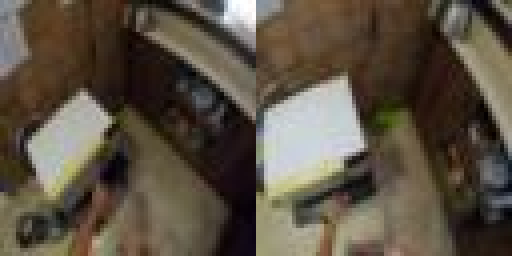

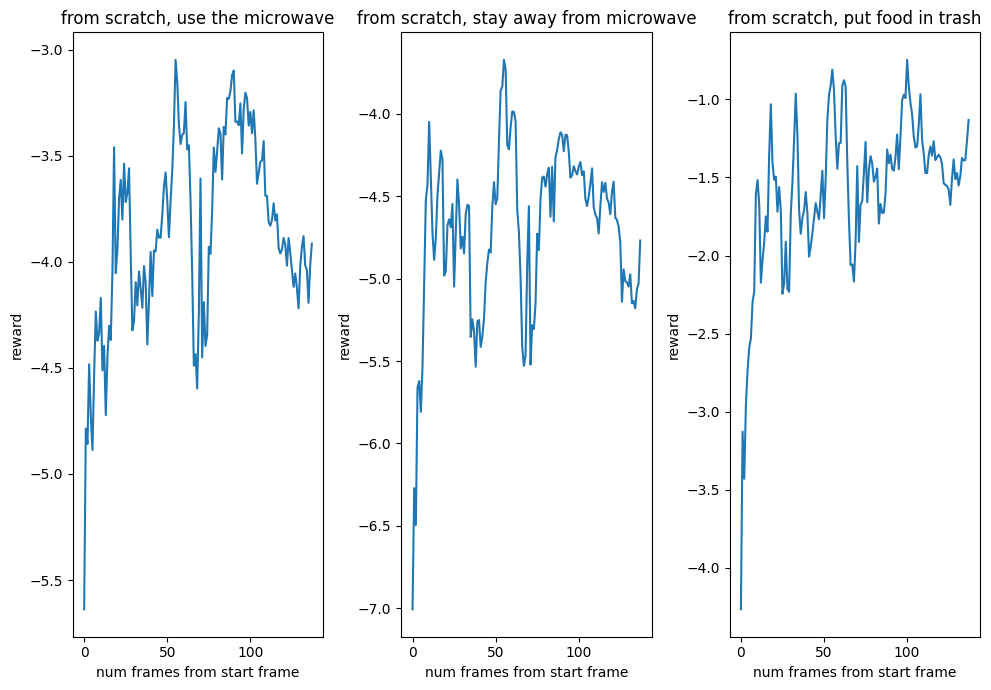

In [127]:
import numpy as np
from PIL import Image, ImageSequence
from r3m.utils.data_loaders import R3MBuffer
import pandas as pd
import torchvision
import pdb

if ego4d_preprocessing:
    vid = vidpath
    vidlen = len(images)
else:
    vidlen = end_frame - start_frame
label = "use the microwave"
lang = np.array([label])
label_inv = "stay away from microwave"
label_alt = "put food in trash"
lang_inv = np.array([label_inv])
lang_alt = np.array([label_alt])
resize = torch.nn.Upsample(224, mode='bilinear', align_corners=False)
if ego4d_preprocessing:
    start_image = torchvision.io.read_image(f"{vid}/{vid_csv.start_frame:07}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vid_csv.end_frame:07}.jpg")
else:
    start_image = torchvision.io.read_image(f"{vid}/{0}.jpg")
    end_image = torchvision.io.read_image(f"{vid}/{vidlen-1}.jpg")
start = resize((start_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in range(vidlen):
    if ego4d_preprocessing:
        index = vid_csv.start_frame + index
        end = torchvision.io.read_image(f"{vid}/{index:07}.jpg")
    else:
        end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end.to('cuda:0'))
    rewards_scratch.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
    rewards_scratch_inv.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_inv)[0].cpu().detach())
    rewards_scratch_alt.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_alt)[0].cpu().detach())
    
show_images_rlbench(torch.stack([start_image, end_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0].plot(rewards_scratch)
axs[0].set(xlabel="num frames from start frame", ylabel="reward")
axs[0].set_title("from scratch, " + label)

axs[1].plot(rewards_scratch_inv)
axs[1].set(xlabel="num frames from start frame", ylabel="reward")
axs[1].set_title("from scratch, " + label_inv)

axs[2].plot(rewards_scratch_alt)
axs[2].set(xlabel="num frames from start frame", ylabel="reward")
axs[2].set_title("from scratch, " + label_alt)

fig.tight_layout()


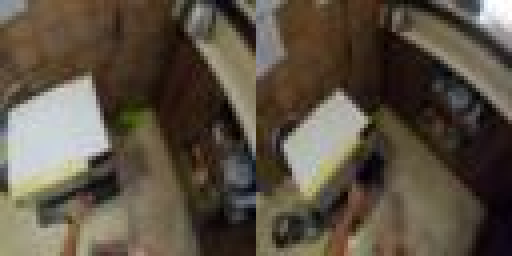

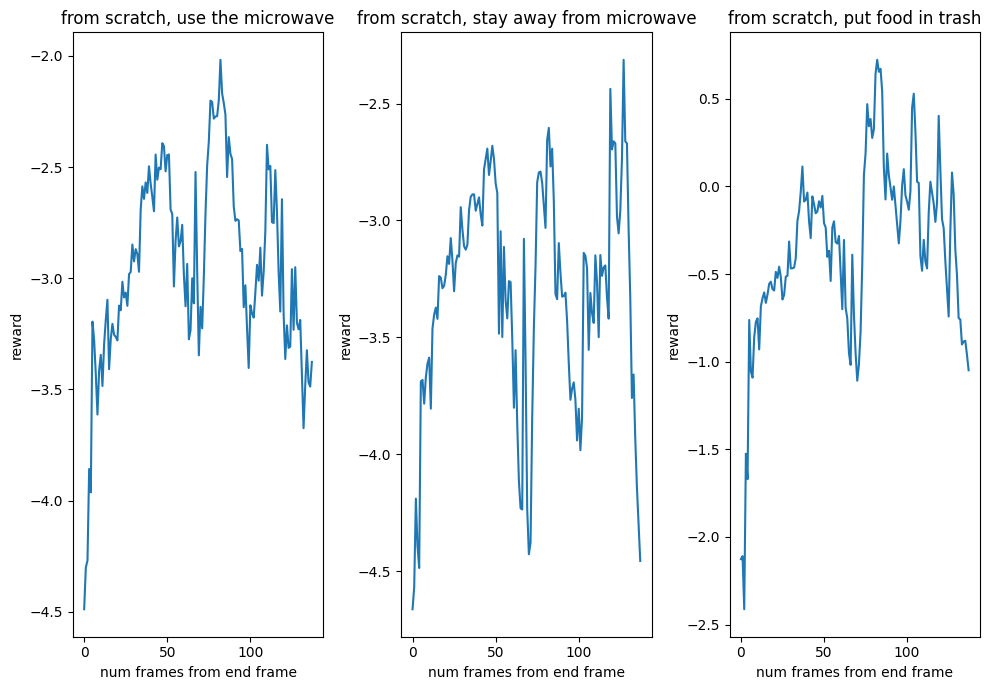

In [128]:
start = resize((end_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in reversed(range(vidlen)):
    if ego4d_preprocessing:
        index = vid_csv.start_frame + index
        end = torchvision.io.read_image(f"{vid}/{index:07}.jpg")
    else:
        end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end.to('cuda:0'))
    rewards_scratch.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
    rewards_scratch_inv.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_inv)[0].cpu().detach())
    rewards_scratch_alt.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_alt)[0].cpu().detach())
    
show_images_rlbench(torch.stack([end_image, start_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0].plot(rewards_scratch)
axs[0].set(xlabel="num frames from end frame", ylabel="reward")
axs[0].set_title("from scratch, " + label)

axs[1].plot(rewards_scratch_inv)
axs[1].set(xlabel="num frames from end frame", ylabel="reward")
axs[1].set_title("from scratch, " + label_inv)

axs[2].plot(rewards_scratch_alt)
axs[2].set(xlabel="num frames from end frame", ylabel="reward")
axs[2].set_title("from scratch, " + label_alt)

fig.tight_layout()
